In [78]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Add src to path
import sys
sys.path.append('..')

from src.config import RAW_DATA_PATH, CLEANED_DATA_PATH, TARGET_COLUMN, DATE_COLUMN
from src.data_preprocessing import (
    load_data, convert_datetime, check_missing_values,
    handle_missing_values, handle_duplicates, handle_outliers_iqr,
    check_time_continuity, resample_hourly, preprocess_pipeline
)
from src.utils import save_csv

from sklearn.preprocessing import MultiLabelBinarizer

print("Libraries imported successfully!")

Libraries imported successfully!


## 2.1 Load Raw Data

In [79]:
# Load data
df = load_data(RAW_DATA_PATH)
print(f"\nOriginal shape: {df.shape}")
df.head()

Loaded data: 48204 rows, 9 columns

Original shape: (48204, 9)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


## 2.2 Handle DateTime

In [80]:
# Convert datetime and sort
df = convert_datetime(df, DATE_COLUMN)
df.head()

Date range: 2012-10-02 09:00:00 to 2018-09-30 23:00:00


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


## 2.3 Handle Duplicates

In [81]:
# Check duplicates before
print(f"Duplicate timestamps before: {df[DATE_COLUMN].duplicated().sum()}")

df = df.groupby("date_time", as_index=False).agg({
    "temp": "mean",
    "rain_1h": "max",       # nếu có mưa ở bất kỳ dòng nào → giữ lại
    "snow_1h": "max",
    "clouds_all": "mean",
    "traffic_volume": "mean",

    # weather → gộp thành chuỗi không trùng
    "weather_main": lambda x: ",".join(sorted(set(x))),
    "weather_description": lambda x: ",".join(sorted(set(x))),

    # holiday → nếu có dòng nào không NaN thì coi là có holiday
    "holiday": lambda x: 0 if x.isna().all() else 1
})


Duplicate timestamps before: 7629


In [82]:
df["weather_main"] = df["weather_main"].str.split(",")

mlb = MultiLabelBinarizer()
weather_vec = mlb.fit_transform(df["weather_main"])

weather_df = pd.DataFrame(weather_vec, columns=mlb.classes_, index=df.index)

df = pd.concat([df.drop(columns="weather_main"), weather_df], axis=1)

In [83]:
df.head()

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume,weather_description,holiday,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Squall,Thunderstorm
0,2012-10-02 09:00:00,288.28,0.0,0.0,40.0,5545.0,scattered clouds,0,0,1,0,0,0,0,0,0,0,0,0
1,2012-10-02 10:00:00,289.36,0.0,0.0,75.0,4516.0,broken clouds,0,0,1,0,0,0,0,0,0,0,0,0
2,2012-10-02 11:00:00,289.58,0.0,0.0,90.0,4767.0,overcast clouds,0,0,1,0,0,0,0,0,0,0,0,0
3,2012-10-02 12:00:00,290.13,0.0,0.0,90.0,5026.0,overcast clouds,0,0,1,0,0,0,0,0,0,0,0,0
4,2012-10-02 13:00:00,291.14,0.0,0.0,75.0,4918.0,broken clouds,0,0,1,0,0,0,0,0,0,0,0,0


## 2.4 Handle Missing Values

In [84]:
# Check missing values
missing_df = check_missing_values(df)
if len(missing_df) > 0:
    print("Missing values found:")
    print(missing_df)
else:
    print("No missing values found!")

No missing values found!


## 2.5 Handle Outliers

Column 'traffic_volume': 0 outliers handled (method=clip)


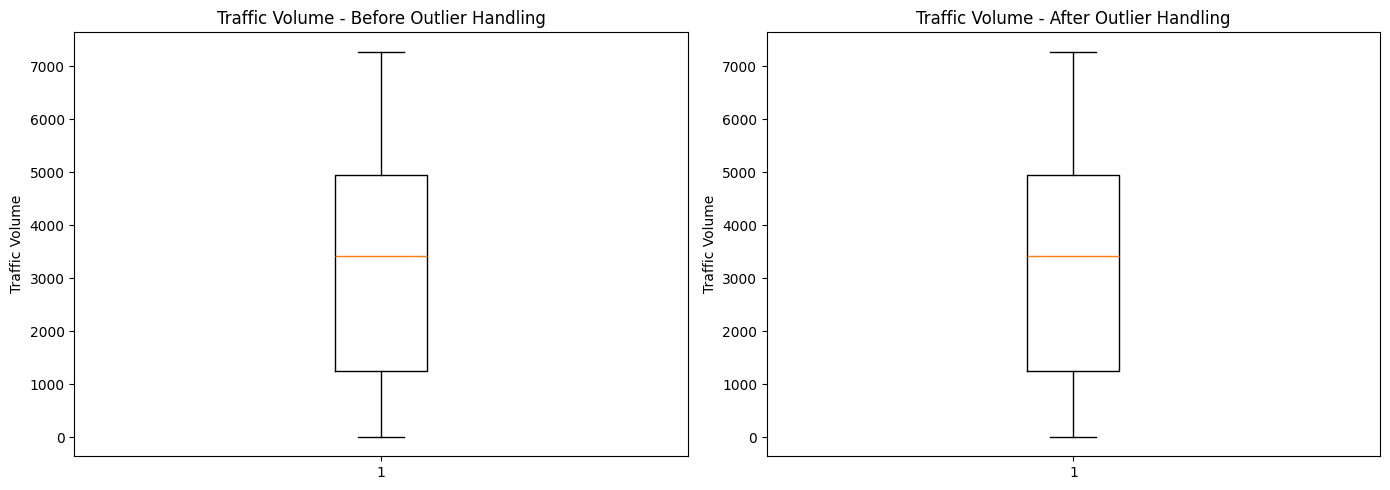

In [85]:
# Visualize outliers before handling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].boxplot(df[TARGET_COLUMN])
axes[0].set_title('Traffic Volume - Before Outlier Handling')
axes[0].set_ylabel('Traffic Volume')

# Handle outliers
df = handle_outliers_iqr(df, TARGET_COLUMN, factor=1.5, method='clip')

axes[1].boxplot(df[TARGET_COLUMN])
axes[1].set_title('Traffic Volume - After Outlier Handling')
axes[1].set_ylabel('Traffic Volume')

plt.tight_layout()
plt.show()

## 2.6 Check Time Continuity

**Lưu ý cho Seq2Seq:** Không cần resample/interpolate vì:
- Interpolate target = data leakage
- Chỉ cần tạo sequences từ các đoạn dữ liệu liên tục thực sự có

In [86]:
# Check for missing timestamps (chỉ kiểm tra, không xử lý)
df_temp = df.set_index(DATE_COLUMN)
full_range = pd.date_range(start=df_temp.index.min(), end=df_temp.index.max(), freq='H')
n_missing = len(full_range) - len(df_temp)

print(f"Expected hourly timestamps: {len(full_range)}")
print(f"Actual timestamps: {len(df_temp)}")
print(f"Missing timestamps: {n_missing}")

# Với Seq2Seq: Chỉ tạo sequences từ dữ liệu thực có
# → Không cần resample/interpolate vì sẽ xử lý trong Data Preparation
if n_missing > 0:
    print(f"\n⚠️ Có {n_missing} timestamps bị thiếu.")
    print("→ Sẽ xử lý bằng cách tạo sequences từ các đoạn liên tục trong Data Preparation.")

Expected hourly timestamps: 52551
Actual timestamps: 40575
Missing timestamps: 11976

⚠️ Có 11976 timestamps bị thiếu.
→ Sẽ xử lý bằng cách tạo sequences từ các đoạn liên tục trong Data Preparation.


## 2.7 Data Validation

In [87]:
# Final validation
print("=" * 50)
print("DATA VALIDATION")
print("=" * 50)
print(f"Shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate timestamps: {df[DATE_COLUMN].duplicated().sum()}")
print(f"Date range: {df[DATE_COLUMN].min()} to {df[DATE_COLUMN].max()}")
print(f"\nTarget column ({TARGET_COLUMN}) statistics:")
print(df[TARGET_COLUMN].describe())
print("=" * 50)

DATA VALIDATION
Shape: (40575, 19)
Missing values: 0
Duplicate timestamps: 0
Date range: 2012-10-02 09:00:00 to 2018-09-30 23:00:00

Target column (traffic_volume) statistics:
count    40575.000000
mean      3290.650474
std       1984.772909
min          0.000000
25%       1248.500000
50%       3427.000000
75%       4952.000000
max       7280.000000
Name: traffic_volume, dtype: float64


In [88]:
# View cleaned data
df.head(10)

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume,weather_description,holiday,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Squall,Thunderstorm
0,2012-10-02 09:00:00,288.28,0.0,0.0,40.0,5545.0,scattered clouds,0,0,1,0,0,0,0,0,0,0,0,0
1,2012-10-02 10:00:00,289.36,0.0,0.0,75.0,4516.0,broken clouds,0,0,1,0,0,0,0,0,0,0,0,0
2,2012-10-02 11:00:00,289.58,0.0,0.0,90.0,4767.0,overcast clouds,0,0,1,0,0,0,0,0,0,0,0,0
3,2012-10-02 12:00:00,290.13,0.0,0.0,90.0,5026.0,overcast clouds,0,0,1,0,0,0,0,0,0,0,0,0
4,2012-10-02 13:00:00,291.14,0.0,0.0,75.0,4918.0,broken clouds,0,0,1,0,0,0,0,0,0,0,0,0
5,2012-10-02 14:00:00,291.72,0.0,0.0,1.0,5181.0,sky is clear,0,1,0,0,0,0,0,0,0,0,0,0
6,2012-10-02 15:00:00,293.17,0.0,0.0,1.0,5584.0,sky is clear,0,1,0,0,0,0,0,0,0,0,0,0
7,2012-10-02 16:00:00,293.86,0.0,0.0,1.0,6015.0,sky is clear,0,1,0,0,0,0,0,0,0,0,0,0
8,2012-10-02 17:00:00,294.14,0.0,0.0,20.0,5791.0,few clouds,0,0,1,0,0,0,0,0,0,0,0,0
9,2012-10-02 18:00:00,293.10,0.0,0.0,20.0,4770.0,few clouds,0,0,1,0,0,0,0,0,0,0,0,0


## 2.8 Save Cleaned Data

In [89]:
# Save to CSV
save_csv(df, CLEANED_DATA_PATH, index=False)

print(f"\nCleaned data saved to: {CLEANED_DATA_PATH}")

Saved: d:\DeepLearning_final\data\processed\cleaned_data.csv

Cleaned data saved to: d:\DeepLearning_final\data\processed\cleaned_data.csv


## Summary

**Preprocessing steps completed:**
1. ✅ Converted datetime column
2. ✅ Sorted by timestamp
3. ✅ Removed duplicate timestamps  
4. ✅ Handled missing values (trong features)
5. ✅ Handled outliers using IQR method
6. ✅ Checked time continuity (không resample - giữ nguyên data thật)
7. ✅ Saved cleaned data

**Lưu ý:** Missing timestamps sẽ được xử lý trong Data Preparation bằng cách tạo sequences từ các đoạn liên tục.

**Next step:** Feature Engineering (03_Feature_Engineering.ipynb)